In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set(style='whitegrid')
sys.path.append('..')

from load_data import *

### Load the data

In [66]:
df = load_dataset('../data/DataTrain.txt')
df = df.set_index('engine_id')

df = df.drop(['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1)

df_test  = df[df.index >= 80]
df_train = df[df.index < 80]

### Get the remaining time for each engine

In [69]:
def get_ruls(dataframe):
    """
    Get the ruls of the engines
    """
    # Try to drop max cycle to prevent an error
    dataframe = dataframe.drop('max_cycle', 1, errors='ignore')
    
    # The max cycle of each engine
    max_cycle = dataframe.groupby('engine_id').agg({'cycle': 'max'}).rename({'cycle': 'max_cycle'}, axis=1)
    
    # Add the max cycle to the dataframe
    dataframe = dataframe.join(max_cycle, on='engine_id', )
    
    # Ruls are max cycle minus current cycle (plus 1)
    ruls = (dataframe['max_cycle'] - dataframe['cycle'] + 1).values
    
    return ruls

df_train.loc[:, 'rul'] = get_ruls(df_train)
df_test.loc[:, 'rul']  = get_ruls(df_test)

df_train[['cycle', 'rul']].tail()

,cycle,rul
engine_id,,
79,195,5
79,196,4
79,197,3
79,198,2
79,199,1


### Plot the timeseries of the engines

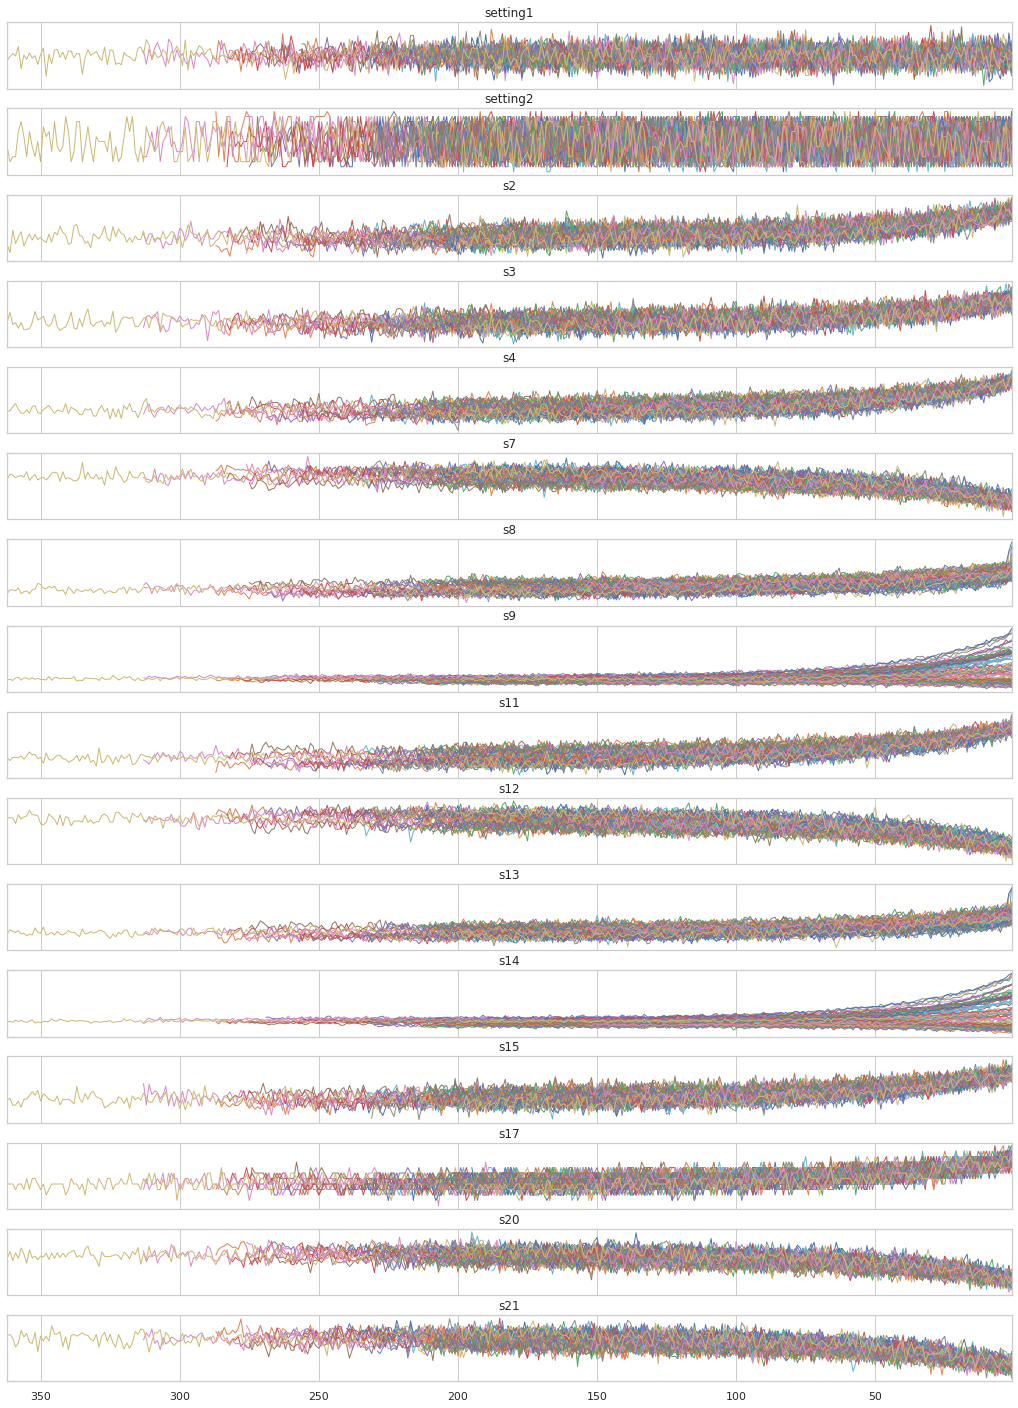

In [88]:
def plot_timeseries(dataframe):
    ts = dataframe.copy()
    
    max_rul = ts['rul'].max()
    
    ts.drop(labels=['cycle'], axis=1, inplace=True)

    cols = ts.columns
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(18,25), sharex=True)

    for col, ax in zip(cols, axes):
        if col == 'rul':
            continue

        ax.set_title(col, fontdict={'fontsize': 12})
        ax.set_xlim(max_rul, 1)
        ax.get_yaxis().set_visible(False)

        for engine_id in ts.index.unique():
            time = ts.loc[engine_id, 'rul']
            ax.plot(time, ts.loc[engine_id,col], label=col, linewidth=1)

    plt.subplots_adjust(hspace=0.3)
    
plot_timeseries(df_train)

### Normalize the sensors

In [74]:
from sklearn.preprocessing import StandardScaler

In [85]:
df_train_norm = df_train.copy()
df_test_norm  = df_test.copy()

scaler = StandardScaler()

df_train_norm.iloc[:, 1:-1] = scaler.fit_transform(df_train.iloc[:, 1:-1])
df_test_norm.iloc[:, 1:-1]  = scaler.transform(df_test.iloc[:, 1:-1])

df_train_norm.head()

,cycle,setting1,setting2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
engine_id,,,,,,,,,,,,,,,,,,
1,1,-0.324943,-1.360954,-1.724290,-0.140042,-0.933033,1.119792,-0.516462,-0.844726,-0.272306,0.340332,-1.050151,-0.265738,-0.609998,-0.787145,1.351058,1.195241,192
1,2,0.863995,-1.020844,-1.065897,0.205761,-0.650607,0.434679,-0.794585,-0.938194,-0.197667,1.177690,-0.364270,-0.628411,-0.282658,-0.787145,1.019996,1.237545,191
1,3,-1.971164,1.019820,-0.666870,-0.418968,-0.532745,1.007478,-0.238339,-0.547129,-1.018703,1.366771,-0.912975,-0.539904,-0.655240,-2.077524,0.744112,0.507328,190
1,4,0.315254,-0.000512,-0.666870,-1.267163,-0.791820,1.220874,0.178846,-0.699675,-1.541180,1.961025,-0.227094,-0.509385,-1.975247,-0.787145,0.357873,0.780470,189
1,5,-0.873683,-0.680733,-0.626968,-1.257377,-0.308138,0.715463,-0.516462,-0.449693,-0.981383,1.056138,-0.775799,-0.510911,-0.346529,-0.141955,0.468227,1.060969,188


### Linear regression on the slopes

In [87]:
from sklearn.linear_model import LinearRegression

In [89]:
lin_model = LinearRegression()

In [95]:
engine_num = 1

x = df_train_norm.loc[engine_num, 'rul'].values

row_name=df_train_norm.loc[engine_num].iloc[-1].name
row_sl=df_train_norm.index.get_loc(row_name) # row slice to get numpy index 
y=df_train_norm[row_sl]
x.reshape(-1, 1).shape
# lin_model.fit(x.reshape(-1, 1),y)
# lin_model.score(x.reshape(-1, 1),y)

(192, 1)

In [96]:
x

array([192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180,
       179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167,
       166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154,
       153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141,
       140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128,
       127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115,
       114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102,
       101, 100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,
        88,  87,  86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,
        75,  74,  73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,
        62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,
        49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,
        36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,
        23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  1